In [1]:
import pandas as pd
import numpy as np
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
from datetime import datetime
from country_list import countries_for_language
countries_list = dict(countries_for_language('en'))

data_folder = './data/'

### Import data set on character: 

In this project, we are going to work on the representation of the ethnicity on movies from different datas. We have approximately 450 000 characters aligned in the file `'character.metadata.tsv'` which datas are extracted from November 4 2012 , dump of freebase. It is the main data that we are going to use, as it contains the ID of the ethnicity. We are only going to keep 9 features, as we decided that we would not use other features for our analyses. We will also drop the character with non-defined ethnicity. We also remove the data after 2012 as our datas are extracted from 2012.

In [33]:
data1 = pd.read_csv(data_folder + 'character.metadata.tsv', sep='\t', header=None)

def format_attr(df):
     '''
     Create a new dataframe with all attributes
     formatted according to the character data set'
     :param dataframe: pandas.DataFrame
     :return: new dataframe
     '''
     formatted_df = pd.DataFrame()
     formatted_df['wikipedia_id'] = df[df.columns[0]].astype(int)
     formatted_df['freebase_movie_id'] = df[df.columns[1]].astype(str)
    
     formatted_df['date'] = df[df.columns[2]]
     formatted_df['date'] = pd.to_datetime(formatted_df['date'])
     formatted_df['date'] = pd.DatetimeIndex(formatted_df['date']).year
    
     formatted_df['character_name'] = df[df.columns[3]].astype(str)
     formatted_df['gender'] = df[df.columns[5]].astype(str)
     formatted_df['ethnicity'] = df[df.columns[7]].astype(str)
     formatted_df['name'] = df[df.columns[8]].astype(str, errors='ignore')
     formatted_df['age'] = df[df.columns[9]].astype(int, errors='ignore')
     formatted_df['freebase_actor_character_id'] = df[df.columns[10]].astype(str)
     formatted_df['freebase_actor_id'] = df[df.columns[12]].astype(str)
     formatted_df['freebase_character_id'] = df[df.columns[11]].astype(str)
        
     return formatted_df

data1 =  data1[data1[data1.columns[7]].notna()]
charac_data = format_attr(data1)

#sort by datetime of movie and remove data after 2012
charac_data = charac_data.sort_values(by='date')
charac_data = charac_data[charac_data.date < 2013]
charac_data.head()

,wikipedia_id,freebase_movie_id,date,character_name,gender,ethnicity,name,age,freebase_actor_character_id,freebase_actor_id,freebase_character_id
72684,644824,/m/02_1qn,1891.0,nan,M,/m/03lmx1,William Dickson,NaN,/m/0jx879,/m/081ks,nan
342275,786716,/m/03c6bq,1894.0,nan,M,/m/03lmx1,William Dickson,NaN,/m/0lqhqw3,/m/081ks,nan
190378,12266752,/m/02vy7q4,1896.0,nan,M,/m/063k3h,William McKinley,NaN,/m/0mzm_t4,/m/083p7,nan
354987,15128774,/m/03hjd3w,1900.0,Prince Hamlet,F,/m/041rx,Sarah Bernhardt,NaN,/m/05x7bw_,/m/0c4qt,/m/0261d9m
221932,76026,/m/0k2vz,1901.0,nan,M,/m/063k3h,William McKinley,NaN,/m/0lml09m,/m/083p7,nan


For our first data set, we will only keep the following features : 

`wikipedia_id` : Wikipedia movie ID \
`freebase_movie_id` :  Freebase movie ID \
`date` :  Movie release date \
`wikipedia_id` : Character name \
`gender` : Actor gender \
`ethnicity` : Actor ethnicity (Freebase ID) \
`name` : Actor name \
`freebase_character_id` : Freebase character ID \
`freebase_actor_id` : Freebase actor ID

In [35]:
population_per_ethnicity = charac_data['ethnicity'].value_counts()
ethnicity_array = charac_data['ethnicity'].unique()

print("We keep only " + str(len(charac_data)) + " samples.")
print("We can see the occurence of each of the 477 ethnicity:")
print(population_per_ethnicity)

We keep only 102372 samples.
We can see the occurence of each of the 477 ethnicity:
/m/0dryh9k    15449
/m/0x67        9983
/m/041rx       9813
/m/02w7gg      5996
/m/033tf_      3801
              ...  
/m/043_z22        1
/m/0dm3xpw        1
/m/0c50f          1
/m/05ysft4        1
/m/09c8kp         1
Name: ethnicity, Length: 477, dtype: int64


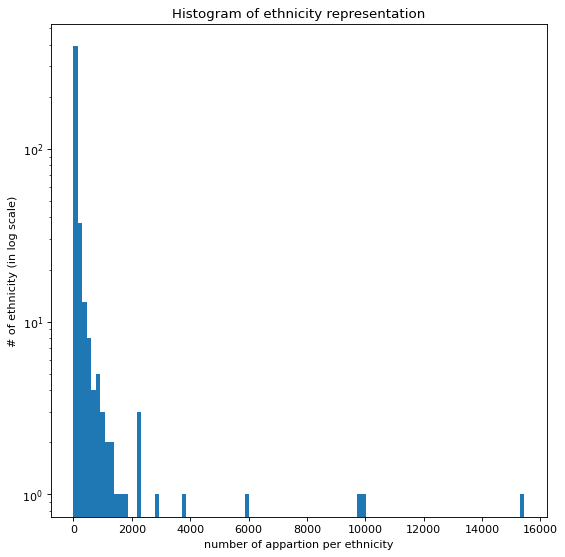

In [22]:
figure(figsize=(8,8), dpi=80)

plt.hist(charac_data['ethnicity'].value_counts().values, bins=100, log = True)[-1]

plt.title('Histogram of ethnicity representation')
plt.ylabel('# of ethnicity (in log scale)')
plt.xlabel('number of appartion per ethnicity')
plt.show()

We can see that a fair proportion of ethnicity are poorly represented. A lot of ethnicity have only a few number of appartion while a few seem to be highly represented. Let's try to vizualise the evolution over the years.

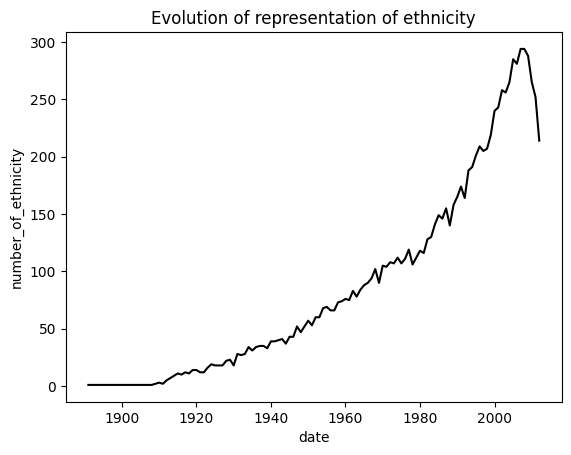

In [36]:
#plot of when ethnicity was finally starred in a movie

date_charac = charac_data.groupby(charac_data['date']).apply(lambda x: pd.Series({
        'num_of_ethnicity': x['ethnicity'].nunique(),
    }))

plt.plot(date_charac.index, date_charac.num_of_ethnicity, color = 'black')

plt.title('Evolution of representation of ethnicity')
plt.ylabel('number_of_ethnicity')
plt.xlabel('date')
plt.show()

We can see that there is a clear evolution of representation of ethnicity over the years. Is it because each country has now the capability to do movies or if there is really an increase of representation. Is there a bias because of more movies are produced each years ? 

Let's look at the actors with more dans 50 apparition.

In [8]:
top_charac = charac_data.groupby(charac_data['name']).apply(lambda x: pd.Series({
        'ethnicity' : x['ethnicity'].unique()[0],
        'number_of_apparition': len(x['freebase_movie_id'])
    }))


top_charac = top_charac.sort_values(by='number_of_apparition',ascending=False)[top_charac.number_of_apparition > 50]

/var/folders/69/0nl_j5rj5_nd4ny0wdz_l3lm0000gn/T/ipykernel_35971/613045343.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  top_charac = top_charac.sort_values(by='number_of_apparition',ascending=False)[top_charac.number_of_apparition > 50]


In [9]:
top_charac

,ethnicity,number_of_apparition
name,,
Mel Blanc,/m/041rx,648
Oliver Hardy,/m/07bch9,298
Mithun Chakraborty,/m/0bpjh3,297
Mohanlal,/m/0dryh9k,223
Mammootty,/m/04mvp8,210
...,...,...
Saif Ali Khan,/m/0bpjh3,51
Bruce Greenwood,/m/044038p,51
Suresh Oberoi,/m/0dryh9k,51


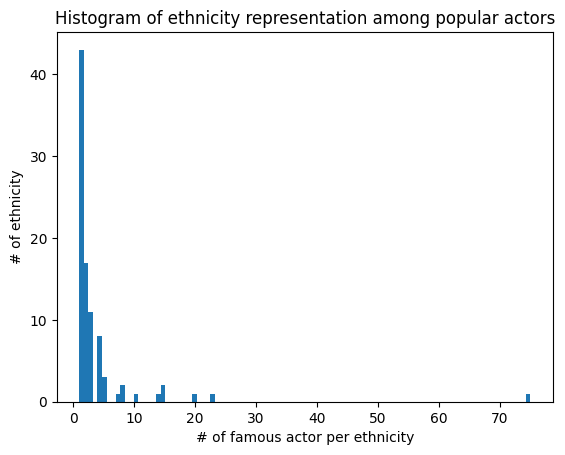

In [10]:
plt.hist(top_charac['ethnicity'].value_counts().values, bins=100)[-1]

plt.title('Histogram of ethnicity representation among popular actors')
plt.ylabel('# of ethnicity')
plt.xlabel('# of famous actor per ethnicity')
plt.show()

We can spot an outlier. There is an ethnicity with a huge number of popular actor. Some other ethnicity have a few popular actor. Can we really say that those ethnicity are well represented ? 

We are also going to use the file `'movie.metadata'` which we are going to merge with the previous dataframe. This new dataframe will contain in addition several more features, like the countries of the movies and the revenue.

In [98]:
data2 = pd.read_csv(data_folder + 'movie.metadata.tsv', sep='\t', header=None)
def format_attr2(df):
     '''
     Create a new dataframe with all attributes
     formatted according to the character data set'
     :param dataframe: pandas.DataFrame
     :return: new dataframe
     '''
     formatted_df = pd.DataFrame()
     formatted_df['wikipedia_id'] = df[df.columns[0]].astype(int)
     formatted_df['movie_name'] = df[df.columns[2]].astype(str)    
     formatted_df['revenue'] = df[df.columns[4]].astype(int, errors='ignore')
     formatted_df['runtime'] = df[df.columns[5]].astype(int, errors='ignore')
     formatted_df['movie_languages'] = df[df.columns[6]].astype(str)
     formatted_df['movie_countries'] = df[df.columns[7]]
     formatted_df['movie_genres'] = df[df.columns[8]].astype(str)
        
     return formatted_df


movie_data = format_attr2(data2)
movie_data.head(10)

,wikipedia_id,movie_name,revenue,runtime,movie_languages,movie_countries,movie_genres
0,975900,Ghosts of Mars,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,Brun bitter,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,White Of The Eye,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,A Woman in Flames,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"
5,13696889,The Gangsters,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen..."
6,18998739,The Sorcerer's Apprentice,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0hzlz"": ""South Africa""}","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant..."
7,10408933,Alexander's Ragtime Band,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ..."
8,9997961,Contigo y aquí,NaN,NaN,"{""/m/06nm1"": ""Spanish Language""}","{""/m/0jgd"": ""Argentina""}","{""/m/04t36"": ""Musical"", ""/m/07s9rl0"": ""Drama"",..."
9,2345652,City of the Dead,NaN,76.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/03npn"": ""Horror"", ""/m/0fdjb"": ""Supernatur..."


In [99]:
movie_data = movie_data[movie_data['wikipedia_id'].isin(charac_data['wikipedia_id'])]
merged_data = pd.merge(charac_data, movie_data, left_on='wikipedia_id', right_on='wikipedia_id', how = 'left')
merged_data

,wikipedia_id,freebase_movie_id,date,character_name,gender,ethnicity,name,age,freebase_actor_character_id,freebase_actor_id,freebase_character_id,movie_name,revenue,runtime,movie_languages,movie_countries,movie_genres
0,644824,/m/02_1qn,1891.0,nan,M,/m/03lmx1,William Dickson,NaN,/m/0jx879,/m/081ks,nan,Dickson Greeting,NaN,0.05,{},"{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/0219x_"": ""Indie""}"
1,786716,/m/03c6bq,1894.0,nan,M,/m/03lmx1,William Dickson,NaN,/m/0lqhqw3,/m/081ks,nan,Dickson Experimental Sound Film,NaN,0.00,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film""}"
2,12266752,/m/02vy7q4,1896.0,nan,M,/m/063k3h,William McKinley,NaN,/m/0mzm_t4,/m/083p7,nan,"McKinley at Home, Canton, Ohio",NaN,1.00,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen..."
3,15128774,/m/03hjd3w,1900.0,Prince Hamlet,F,/m/041rx,Sarah Bernhardt,NaN,/m/05x7bw_,/m/0c4qt,/m/0261d9m,Hamlet,NaN,2.00,{},"{""/m/0f8l9c"": ""France""}","{""/m/02hmvc"": ""Short Film"", ""/m/07s9rl0"": ""Dra..."
4,76026,/m/0k2vz,1901.0,nan,M,/m/063k3h,William McKinley,NaN,/m/0lml09m,/m/083p7,nan,President McKinley Inauguration Footage,NaN,NaN,{},"{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film"", ""/m/0219x_"": ""Indi..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102367,30672494,/m/0g9xjv9,2012.0,nan,M,/m/0cqgdq,Rajnikanth,61.0,/m/0gw218j,/m/02wmbg,nan,Rana,NaN,NaN,"{""/m/03k50"": ""Hindi Language"", ""/m/09s02"": ""Te...","{""/m/03rk0"": ""India""}","{""/m/02kdv5l"": ""Action"", ""/m/07s9rl0"": ""Drama""}"
102368,32985148,/m/0h533hm,2012.0,Raghu,M,/m/0dryh9k,Jiiva,27.0,/m/0h58g5n,/m/0j46lfy,/m/0h8mh95,Neethaane En Ponvasantham,NaN,NaN,"{""/m/07c9s"": ""Tamil Language""}",{},"{""/m/02l7c8"": ""Romance Film""}"
102369,23690065,/m/0gxz14q,2012.0,nan,F,/m/01rv7x,Anupama Kumar,37.0,/m/0hzw16b,/m/080kws4,nan,Mugamoodi,NaN,NaN,{},{},"{""/m/04pbhw"": ""Superhero movie""}"
102370,35997584,/m/0j_5r7f,2012.0,nan,M,/m/041rx,Eli Roth,40.0,/m/0mzm4dl,/m/058kqy,nan,Aftershock,NaN,90.00,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/03npn"": ""Horror""}"


Here we get the data merged between character data and movie data.
From this data set, we want to see which country has the most diversity.

Let's try to clean the `movie_countries` feature corresponding to get a clean array.

In [139]:
import ast
def map_to_country(row, pick_one=False):
    vals = list(ast.literal_eval(row.movie_countries).values())
    pick_one = False if not vals else pick_one
    return vals if not pick_one else [vals[0]]

In [135]:
df = merged_data.copy()
df["movie_countries"] = df.apply(lambda x: map_to_country(x, False), axis =1)

In [138]:
df.sample(10)

,wikipedia_id,freebase_movie_id,date,character_name,gender,ethnicity,name,age,freebase_actor_character_id,freebase_actor_id,freebase_character_id,movie_name,revenue,runtime,movie_languages,movie_countries,movie_genres
46826,710094,/m/034scm,1997.0,Bazta Sergeant,M,/m/0j4w_,Goran Višnjić,25.0,/m/0cgnwrs,/m/02fc5y,/m/0gg2h3g,The Peacemaker,110463140.0,123.0,"{""/m/02h40lc"": ""English Language"", ""/m/06b_j"":...",[United States of America],"{""/m/01jfsb"": ""Thriller"", ""/m/01drsx"": ""Disast..."
33372,33723973,/m/0crzhfm,1990.0,Mahesh Dholakia,M,/m/0dryh9k,Pankaj Dheer,NaN,/m/0hh6x6w,/m/0cc545z,/m/0hh6x6z,Jeewan Ek Sanghursh,NaN,150.0,"{""/m/03k50"": ""Hindi Language""}",[India],"{""/m/03q4nz"": ""World cinema""}"
41283,508458,/m/02jsh9,1994.0,Ganshyam,M,/m/0dryh9k,Anupam Shyam,36.0,/m/0h800r6,/m/0fqpb49,/m/0h800r8,Bandit Queen,NaN,119.0,"{""/m/03k50"": ""Hindi Language""}","[India, United Kingdom]","{""/m/03q4nz"": ""World cinema"", ""/m/07s9rl0"": ""D..."
69043,4696389,/m/0chvk5,2004.0,nan,M,/m/0x67,50 Cent,29.0,/m/0gxlrqd,/m/01vvyc_,nan,Beef II,NaN,85.0,"{""/m/02h40lc"": ""English Language""}",[],"{""/m/0hj3n07"": ""Culture & Society"", ""/m/017fp""..."
21031,835057,/m/03fpj2,1979.0,"Sheldon S. Kornpett, D.D.S.",M,/m/041rx,Alan Arkin,45.0,/m/0k5gdb,/m/015grj,/m/0h3c3fk,The In-Laws,38200000.0,103.0,"{""/m/02h40lc"": ""English Language"", ""/m/06nm1"":...",[United States of America],"{""/m/0lsxr"": ""Crime Fiction"", ""/m/01z4y"": ""Com..."
5765,24167447,/m/07kd0k_,1950.0,Jim O'Connor,M,/m/09kr66,Kirk Douglas,33.0,/m/0gvy5g4,/m/0j582,/m/0h2wr4j,The Glass Menagerie,NaN,107.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"{""/m/07s9rl0"": ""Drama""}"
37655,33002591,/m/0b604g0,1992.0,Capt. Anju Sinha,F,/m/0dryh9k,Ekta Kapoor,17.0,/m/0h785p6,/m/04j0s3,/m/0h785p8,Tahalka,NaN,NaN,"{""/m/03k50"": ""Hindi Language""}",[India],"{""/m/01chg"": ""Bollywood""}"
32231,2053385,/m/043txz_,1989.0,Aiken Reed,F,/m/041rx,Phoebe Cates,26.0,/m/04dhrld,/m/0151fv,/m/0gz6vcf,Heart of Dixie,1097333.0,95.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"{""/m/04xvlr"": ""Period piece"", ""/m/07s9rl0"": ""D..."
98197,29457801,/m/0ds6hpj,2011.0,Rains,M,/m/02w7gg,Danny Dyer,33.0,/m/0dngmhg,/m/065j4h,/m/0h29ymj,Age of Heroes,NaN,90.0,"{""/m/05f_3"": ""Norwegian Language"", ""/m/02h40lc...",[United Kingdom],"{""/m/082gq"": ""War film""}"
75668,20713272,/m/051wfmp,2006.0,Vincent,M,/m/025_0f0,Bruno Todeschini,43.0,/m/0dk8lz7,/m/04mmyjx,/m/0dk8lwc,7 Years,NaN,86.0,"{""/m/064_8sq"": ""French Language"", ""/m/02h40lc""...","[France, Netherlands]","{""/m/0hn10"": ""LGBT"", ""/m/07s9rl0"": ""Drama""}"
